## Jaccard index
Predicts the species of each binary flash sequence by computing the Jaccard index with literature or population references.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve
from jaccard_index import *

Load binary sequence data, labels, and literature references.

In [2]:
# load sequences
seq_path = '../data/real_data/binary_sequences_4.csv'
df = pd.read_csv(seq_path, delimiter=',', header=None, names=list(range(2000))).dropna(axis='columns', how='all')
# load labels
labels_path = '../data/real_data/flash_data_4.csv'
labels = pd.read_csv(labels_path)
df = pd.concat([labels, df], axis="columns")
# keep only sequences with nf > 1
meta_df = pd.read_csv('../data/params_4species.csv', names=['nf', 'fl', 'ifi', 'sp'])
df = df.loc[meta_df['nf'] > 1].reset_index(drop=True)
# load literature sequences (excludes Bw)
literature_sequences = []
literature_labels = []
header = 0
for l in open('../data/literature_sequences_3.csv'):
    if header > 0:
        header -= 1
        continue
    literature_sequences.append([int(float(x)) for x in l.rstrip().split(',')[1:]])
    literature_labels.append(l.rstrip().split(',')[0])

Classify using Jaccard index with literature references.

In [3]:
acc, prec, rec, conf_mat, y_true, y_pred, y_score, metrics = jaccardLit(df, literature_sequences)
print('Precision =',prec)
print('Recall =',rec)

Precision = 0.22678304582530584
Recall = 0.17705127256388956


 Plot ROC curve.

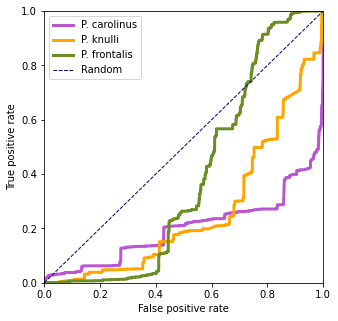

In [4]:
spec_labels=['P. knulli', 'P. frontalis', 'P. carolinus']
fig,ax=plt.subplots(1,1, figsize=(5, 5))
colormap = {0: 'orange', 1: 'olivedrab', 2: 'mediumorchid', 3: 'dodgerblue'}
fprs = []
tprs = []
for i, sp in enumerate([2,0,1]):
    fpr, tpr, thresholds = roc_curve(y_true, y_score[:,sp].flatten(), pos_label=sp)
    lw = 3
    ax.plot(
        fpr,
        tpr,
        color=colormap[sp],
        lw=lw,
        label=spec_labels[sp],
    )
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")
ax.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--", label="Random")
plt.legend()
plt.show()

Plot confusion matrix.

[Text(0, 0.5, 'P. carolinus'),
 Text(0, 1.5, 'P. knulli'),
 Text(0, 2.5, 'P. frontalis')]

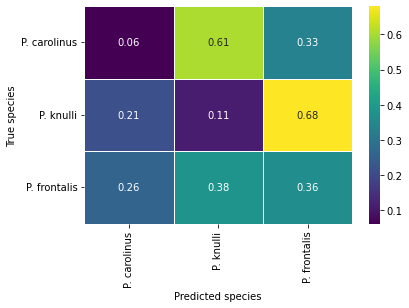

In [5]:
cm2 = np.array([[conf_mat[2,2],conf_mat[2,0],conf_mat[2,1]],
                [conf_mat[0,2],conf_mat[0,0],conf_mat[0,1]],
                [conf_mat[1,2],conf_mat[1,0],conf_mat[1,1]]])

fig,ax = plt.subplots()
sns.heatmap(cm2, linewidths=1, cmap='viridis', ax=ax, annot=True, fmt='.2g')
ax.set_ylabel('True species')
ax.set_xlabel('Predicted species')
ax.set_xticklabels(['P. carolinus', 'P. knulli', 'P. frontalis'], rotation=90)
ax.set_yticklabels(['P. carolinus', 'P. knulli', 'P. frontalis'], rotation=0)

Classify using Jaccard index with population references.

In [6]:
# run for 100 iterations
num_iter = 100
train_split = 0.8
accs, precs, recs, conf_mat, y_true, y_pred, y_score, precs_sp, recs_sp = jaccardPop(df, num_iter, train_split)

In [7]:
print('Overall precision =',np.mean(precs))
print('Overall recall =',np.mean(recs))
print('B. wickershamorum precision =',np.mean(precs_sp[3]))
print('P. carolinus precision =',np.mean(precs_sp[2]))
print('P. knulli precision =',np.mean(precs_sp[0]))
print('P. frontalis precision =',np.mean(precs_sp[1]))
print('B. wickershamorum recall =',np.mean(recs_sp[3]))
print('P. carolinus recall =',np.mean(recs_sp[2]))
print('P. knulli recall =',np.mean(recs_sp[0]))
print('P. frontalis recall =',np.mean(recs_sp[1]))

Overall precision = 0.6279993744287252
Overall recall = 0.7895542675309233
B. wickershamorum precision = 0.17910845674963263
P. carolinus precision = 0.9286770490393199
P. knulli precision = 0.4079068630365339
P. frontalis precision = 0.9963051288894142
B. wickershamorum recall = 0.5266666666666666
P. carolinus recall = 0.7854480556077401
P. knulli recall = 0.9912206148282097
P. frontalis recall = 0.8548817330210774


Plot ROC curve.

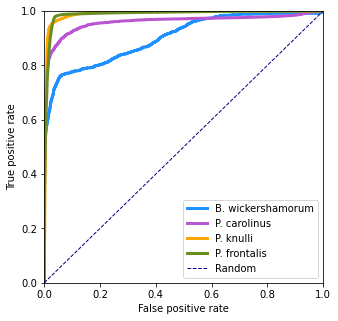

In [8]:
spec_labels=['P. knulli', 'P. frontalis', 'P. carolinus','B. wickershamorum']
fig,ax=plt.subplots(1,1, figsize=(5, 5))
colormap = {0: 'orange', 1: 'olivedrab', 2: 'mediumorchid', 3: 'dodgerblue'}
fprs = []
tprs = []
for i, sp in enumerate([3,2,0,1]):
    fpr, tpr, thresholds = roc_curve(y_true, y_score[:,:,sp].flatten(), pos_label=sp)
    lw = 3
    ax.plot(
        fpr,
        tpr,
        color=colormap[sp],
        lw=lw,
        label=spec_labels[sp],
    )
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")
ax.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--", label="Random")
plt.legend()
plt.show()

Plot confusion matrix.

[Text(0, 0.5, 'Bw'),
 Text(0, 1.5, 'P. carolinus'),
 Text(0, 2.5, 'P. knulli'),
 Text(0, 3.5, 'P. frontalis')]

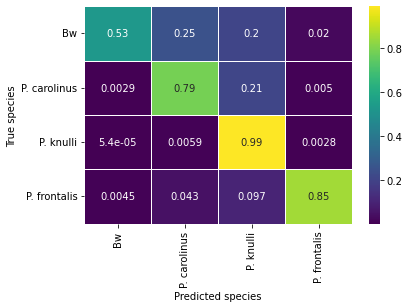

In [9]:
cm2 = np.array([[conf_mat[3,3], conf_mat[3,2],conf_mat[3,0],conf_mat[3,1]],
                [conf_mat[2,3], conf_mat[2,2],conf_mat[2,0],conf_mat[2,1]],
                [conf_mat[0,3], conf_mat[0,2],conf_mat[0,0],conf_mat[0,1]],
                [conf_mat[1,3], conf_mat[1,2],conf_mat[1,0],conf_mat[1,1]]])

fig,ax = plt.subplots()
sns.heatmap(cm2, linewidths=1, cmap='viridis', ax=ax, annot=True, fmt='.2g')
ax.set_ylabel('True species')
ax.set_xlabel('Predicted species')
ax.set_xticklabels(['Bw', 'P. carolinus', 'P. knulli', 'P. frontalis'], rotation=90)
ax.set_yticklabels(['Bw', 'P. carolinus', 'P. knulli', 'P. frontalis'], rotation=0)